In [1]:
import pandas as pd

df = pd.read_csv("../data/cleaned/cleaned_amazon_data.csv")
df.head()


,Order ID,Date,Status,Fulfilment,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-city,ship-state,ship-postal-code,B2B
0,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,406.0,BENGALURU,KARNATAKA,560085.0,False
1,404-0687676-7273146,2022-04-30,Shipped,Amazon,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,329.0,NAVI MUMBAI,MAHARASHTRA,410210.0,True
2,407-1069790-7240320,2022-04-30,Shipped,Amazon,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,574.0,CHENNAI,TAMIL NADU,600073.0,False
3,404-1490984-4578765,2022-04-30,Shipped,Amazon,Expedited,SET264,SET264-KR-NP-XL,Set,XL,B08YN7XDSG,Shipped,1,824.0,GHAZIABAD,UTTAR PRADESH,201102.0,False
4,408-5748499-6859555,2022-04-30,Shipped,Amazon,Expedited,J0095,J0095-SET-L,Set,L,B08CMHNWBN,Shipped,1,653.0,CHANDIGARH,CHANDIGARH,160036.0,False


In [2]:
df["Order ID"] = df["Order ID"].str.replace("-", "", regex=False)

In [3]:
df["Date"] = df["Date"].str.replace("-", "", regex=False)

In [4]:
df["Status"].value_counts()

Status
Shipped                          77580
Shipped - Delivered to Buyer     28754
Cancelled                         5628
Shipped - Returned to Seller      1947
Shipped - Picked Up                973
Pending                            656
Pending - Waiting for Pick Up      281
Shipped - Returning to Seller      145
Shipped - Out for Delivery          35
Shipped - Rejected by Buyer         11
Shipped - Lost in Transit            5
Shipped - Damaged                    1
Name: count, dtype: int64

In [5]:
status_map = {
    # Delivered
    "Shipped": "Delivered",
    "Shipped - Delivered to Buyer": "Delivered",
    "Shipped - Picked Up": "Delivered",
    "Shipped - Out for Delivery": "Delivered",

    # Cancelled
    "Cancelled": "Cancelled",
    "Pending": "Cancelled",
    "Pending - Waiting for Pick Up": "Cancelled",

    # Returned
    "Shipped - Returned to Seller": "Returned",
    "Shipped - Returning to Seller": "Returned",
    "Shipped - Rejected by Buyer": "Returned",
    "Shipped - Lost in Transit": "Returned",
    "Shipped - Damaged": "Returned",
}


In [6]:
df["delivery_status"] = df["Status"].map(status_map)

In [7]:
df = df.dropna(subset=["delivery_status"])

In [8]:
df["delivery_status"].value_counts()

delivery_status
Delivered    107342
Cancelled      6565
Returned       2109
Name: count, dtype: int64

In [9]:
y = df["delivery_status"]

X = df.drop(columns=["delivery_status", "Status", "Courier Status", "Order ID"], errors="ignore")

In [10]:
X = df.drop(columns=["delivery_status", "Status", "Courier Status", "Order ID"], errors="ignore")

cat_cols = X.select_dtypes(exclude="number").columns
X[cat_cols].nunique().sort_values(ascending=False).head(20)


ship-city             8499
SKU                   7132
ASIN                  7128
Style                 1371
Date                    91
ship-state              67
Size                    11
Category                 9
Fulfilment               2
ship-service-level       2
B2B                      2
dtype: int64

In [11]:
#Dropping categoricals with too many unique values
high_card_cols = X[cat_cols].nunique()[lambda s: s > 50].index
high_card_cols

Index(['Date', 'Style', 'SKU', 'ASIN', 'ship-city', 'ship-state'], dtype='object')

In [12]:
X_small = X.drop(columns=high_card_cols)

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

y = df["delivery_status"]

X_encoded = pd.get_dummies(X_small, drop_first=False)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
accuracy



C:\Users\Irish\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Irish\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Irish\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Irish\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Irish\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

0.9201861747974487

In [14]:
orange = "#ed7d31"

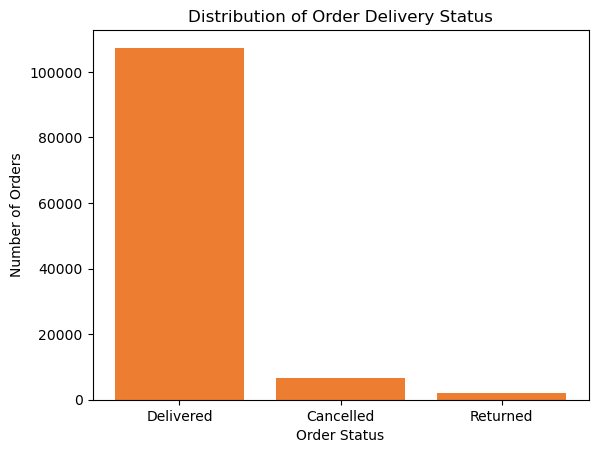

In [15]:
import matplotlib.pyplot as plt

status_counts = df["delivery_status"].value_counts()

plt.bar(status_counts.index, status_counts.values, color = orange)
plt.xlabel("Order Status")
plt.ylabel("Number of Orders")
plt.title("Distribution of Order Delivery Status")
plt.show()


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Cancelled       0.18      0.02      0.04      1313
   Delivered       0.93      0.99      0.96     21469
    Returned       0.23      0.01      0.03       422

    accuracy                           0.92     23204
   macro avg       0.45      0.34      0.34     23204
weighted avg       0.87      0.92      0.89     23204



The model predicts delivered orders very accurately, but struggles to identify cancelled and returned orders because they are much less common in the data.

KNN struggles because rare cancelled and returned orders are overwhelmed by nearby delivered orders in the data (Imbalanced)

In [17]:
from sklearn.metrics import confusion_matrix
LR_confusion_matrix = confusion_matrix(y_test,y_pred)  #Always Actual,Predicted
LR_confusion_matrix

array([[   30,  1283,     0],
       [  133, 21316,    20],
       [    1,   415,     6]], dtype=int64)

In [18]:
train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

In [19]:
train["delivery_status"] = y_train.values

In [20]:
Delivered = train[train["delivery_status"] == 'Delivered']
Cancelled = train[train["delivery_status"] == 'Cancelled']
Returned = train[train["delivery_status"] == 'Returned']

In [21]:
from sklearn.utils import resample
no_undersampled = resample(Delivered,
                                    replace=False,
                                    n_samples = len(Cancelled),
                                    random_state=0)
no_undersampled

,Qty,Amount,ship-postal-code,B2B,Fulfilment_Amazon,Fulfilment_Merchant,ship-service-level_Expedited,ship-service-level_Standard,Category_Blouse,Category_Bottom,...,Size_5XL,Size_6XL,Size_Free,Size_L,Size_M,Size_S,Size_XL,Size_XS,Size_XXL,delivery_status
76074,-0.052586,-0.308456,-0.331084,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,2.163744,-0.390476,-0.440629,-0.304894,-0.407532,Delivered
65155,-0.052586,-0.365019,-1.848694,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,-0.462162,-0.390476,-0.440629,3.279830,-0.407532,Delivered
67675,-0.052586,-0.676120,0.192339,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,2.163744,-0.390476,-0.440629,-0.304894,-0.407532,Delivered
111684,-0.052586,1.678346,0.715307,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,-0.462162,-0.390476,2.269485,-0.304894,-0.407532,Delivered
36802,-0.052586,-0.308456,0.506092,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,2.210621,-0.462162,-0.390476,-0.440629,-0.304894,-0.407532,Delivered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89327,-0.052586,0.278393,-1.476462,-0.083916,-1.602898,1.602898,-1.572118,1.572118,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,-0.462162,-0.390476,2.269485,-0.304894,-0.407532,Delivered
94342,-0.052586,1.812685,1.183862,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,-0.462162,-0.390476,-0.440629,3.279830,-0.407532,Delivered
62278,-0.052586,0.879383,0.192119,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,-0.462162,-0.390476,2.269485,-0.304894,-0.407532,Delivered
94885,-0.052586,-0.311991,-0.844266,-0.083916,-1.602898,1.602898,-1.572118,1.572118,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,-0.462162,-0.390476,-0.440629,-0.304894,2.453794,Delivered


In [22]:
train_under = pd.concat([no_undersampled, Cancelled, Returned])
train_under

,Qty,Amount,ship-postal-code,B2B,Fulfilment_Amazon,Fulfilment_Merchant,ship-service-level_Expedited,ship-service-level_Standard,Category_Blouse,Category_Bottom,...,Size_5XL,Size_6XL,Size_Free,Size_L,Size_M,Size_S,Size_XL,Size_XS,Size_XXL,delivery_status
76074,-0.052586,-0.308456,-0.331084,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,2.163744,-0.390476,-0.440629,-0.304894,-0.407532,Delivered
65155,-0.052586,-0.365019,-1.848694,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,-0.462162,-0.390476,-0.440629,3.279830,-0.407532,Delivered
67675,-0.052586,-0.676120,0.192339,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,2.163744,-0.390476,-0.440629,-0.304894,-0.407532,Delivered
111684,-0.052586,1.678346,0.715307,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,-0.462162,-0.390476,2.269485,-0.304894,-0.407532,Delivered
36802,-0.052586,-0.308456,0.506092,-0.083916,0.623870,-0.623870,0.636085,-0.636085,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,2.210621,-0.462162,-0.390476,-0.440629,-0.304894,-0.407532,Delivered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64687,-0.052586,1.893995,-0.273668,-0.083916,-1.602898,1.602898,-1.572118,1.572118,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,2.210621,-0.462162,-0.390476,-0.440629,-0.304894,-0.407532,Returned
47076,-0.052586,0.426873,1.416548,-0.083916,-1.602898,1.602898,-1.572118,1.572118,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,2.163744,-0.390476,-0.440629,-0.304894,-0.407532,Returned
61588,-0.052586,-1.043784,0.751857,-0.083916,-1.602898,1.602898,-1.572118,1.572118,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,-0.462162,-0.390476,2.269485,-0.304894,-0.407532,Returned
32536,-0.052586,0.306675,-0.312003,-0.083916,-1.602898,1.602898,-1.572118,1.572118,-0.085016,-0.059279,...,-0.066937,-0.077491,-0.055499,-0.452362,-0.462162,-0.390476,-0.440629,-0.304894,-0.407532,Returned


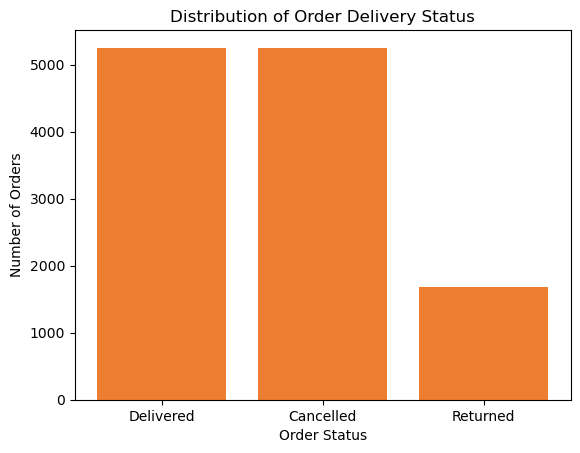

In [23]:
import matplotlib.pyplot as plt

status_counts = train_under['delivery_status'].value_counts()

plt.bar(status_counts.index, status_counts.values, color=orange)
plt.xlabel("Order Status")
plt.ylabel("Number of Orders")
plt.title("Distribution of Order Delivery Status")
plt.show()

In [24]:
x_train = train_under.drop(['delivery_status'], axis = 1)

In [25]:
y_train = train_under['delivery_status']

In [26]:
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [27]:
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
accuracy

C:\Users\Irish\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.4354421651439407

In [28]:
LR_confusion_matrix = confusion_matrix(y_test,y_pred)  #Always Actual,Predicted
LR_confusion_matrix

array([[ 783,  495,   35],
       [9779, 9126, 2564],
       [  41,  186,  195]], dtype=int64)

More true to data. better to work with

Future rec, run other classification models eg- Logistic regression, decision tree classifier 

Why different results for different models